In [517]:
#importamos librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import scipy.stats as stats
from scipy.stats import shapiro, poisson, chisquare, expon, kstest
from itertools import combinations


In [518]:
#defino funcion generica para cargar CSV
def load_csv(path, nrows=None):
    df = pd.read_csv(path, nrows=nrows)
    return df

In [519]:
#Cargo Flight.csv e imprimo las columnas
df_flight = load_csv(r"C:\Users\elaru\OneDrive\Desktop\modulo 3\Customer Flight Activity.csv")
print(df_flight.columns)



Index(['Loyalty Number', 'Year', 'Month', 'Flights Booked',
       'Flights with Companions', 'Total Flights', 'Distance',
       'Points Accumulated', 'Points Redeemed', 'Dollar Cost Points Redeemed'],
      dtype='object')


In [520]:
#funcion pre_eda. me aseguro de la calidad y validacion de datos antes del EDA

def pre_eda(df: pd.DataFrame, name: str = "df"): #una funcion pre-Eda que recibe un dataframe y lo llama df.
    rep = {} #defnine un diccionario donde iran guardando los resuktados del preEda.


    dfc = df.copy()# se crea una copia del dataframe para no trabajar sobre el original.

    # Normaliza columnas
    rep["cols_original"] = list(dfc.columns)#Guarda el nombre de las columnas.Normaliza el texto.Convierte a minuscula,quita espacios,
                                            #cambia los espacios por guiones bajos y eliminia cualquier caracter raro con regex)
    dfc.columns = (
        dfc.columns.str.strip().str.lower()
        .str.replace(" ", "_", regex=True)
        .str.replace("[^0-9a-z_]", "", regex=True)
    )
    rep["cols_limpias"] = list(dfc.columns) #guarda los nombres ya limpios

 
    rep["shape"] = dfc.shape #devuelve funciones basicas de pandas. Devuelve el tamaño y el tipo de dato de cada columna.
    rep["dtypes"] = dfc.dtypes

  
    rep["nulos"] = dfc.isnull().sum().sort_values(ascending=False)#saca los nulos y los duplicados.
    rep["duplicados"] = int(dfc.duplicated().sum())

    # === Print ordenado ===
    print(f"\n== {name.upper()} ==") #Esto es solo para quede bonito en Mayuscula.
    print(f"shape: {rep['shape']}\n")

    print("tipos:")
    print(rep["dtypes"].to_string())#el tipo,nulos,duplicados en texto plano para que no se corte 

    print("Nulos por columna:")
    print(rep["nulos"].to_string())


    print(f"\nDuplicados totales: {rep['duplicados']}")

    return dfc #devuelve en un dataframe limpio 


In [521]:
df_flight_clean = pre_eda(df_flight, "flight")# la llamada para aplicar preEda al CSV Flight



== FLIGHT ==
shape: (405624, 10)

tipos:
loyalty_number                   int64
year                             int64
month                            int64
flights_booked                   int64
flights_with_companions          int64
total_flights                    int64
distance                         int64
points_accumulated             float64
points_redeemed                  int64
dollar_cost_points_redeemed      int64
Nulos por columna:
loyalty_number                 0
year                           0
month                          0
flights_booked                 0
flights_with_companions        0
total_flights                  0
distance                       0
points_accumulated             0
points_redeemed                0
dollar_cost_points_redeemed    0

Duplicados totales: 1864


Customer Flight Activity contiene 405.624 registros y 10 columnas. Los tipos de datos son correctos (identificador, variables temporales en formato numérico y métricas de vuelos y puntos como enteros o decimales). No se detectan valores nulos en ninguna columna. Se identifican 1.864 registros duplicados, que deben analizarse con detalle: algunos pueden ser copias exactas eliminables y otros múltiples registros válidos de un mismo cliente en un mismo mes. En general, el dataset se encuentra en buen estado para continuar con el análisis exploratorio.

In [522]:
df_flight_clean.describe() #para ver los rangos y el resumen estadistico. 

,loyalty_number,year,month,flights_booked,flights_with_companions,total_flights,distance,points_accumulated,points_redeemed,dollar_cost_points_redeemed
count,405624.000000,405624.000000,405624.000000,405624.000000,405624.000000,405624.000000,405624.000000,405624.000000,405624.000000,405624.000000
mean,550037.873084,2017.500000,6.500000,4.115052,1.031805,5.146858,1208.880059,123.692721,30.696872,2.484503
std,258935.286969,0.500001,3.452057,5.225518,2.076869,6.521227,1433.155320,146.599831,125.486049,10.150038
min,100018.000000,2017.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,326961.000000,2017.000000,3.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,550834.000000,2017.500000,6.500000,1.000000,0.000000,1.000000,488.000000,50.000000,0.000000,0.000000
75%,772194.000000,2018.000000,9.250000,8.000000,1.000000,10.000000,2336.000000,239.000000,0.000000,0.000000
max,999986.000000,2018.000000,12.000000,21.000000,11.000000,32.000000,6293.000000,676.500000,876.000000,71.000000


El análisis del describe() muestra que las variables temporales (year, month) son correctas y abarcan de 2016 a 2018, mientras que en varias columnas aparecen muchos valores en cero que reflejan clientes inactivos. La mayoría de los clientes reserva pocos vuelos, viaja solo y acumula o canjea pocos puntos, aunque existen outliers como clientes con más de 20 reservas, hasta 11 acompañantes, distancias de más de 6.000 y redenciones o acumulaciones de puntos muy altas; estos valores no parecen errores, sino casos de clientes muy activos, pero conviene tenerlos en cuenta porque afectan a medias y dispersión en los análisis.




### Customer Flight Analysis.csv
**Loyalty Number:** Este atributo representa un identificador único para cada cliente dentro del programa de lealtad de la aerolínea. Cada número de lealtad corresponde a un cliente específico.
- **Year:** Indica el año en el cual se registraron las actividades de vuelo para el cliente.
- **Month:** Representa el mes del año (de 1 a 12) en el cual ocurrieron las actividades de vuelo.
- **Flights Booked:** Número total de vuelos reservados por el cliente en ese mes específico.
- **Flights with Companions:** Número de vuelos reservados en los cuales el cliente viajó con acompañantes.
- **Total Flights:** El número total de vuelos que el cliente ha realizado.
- **Distance:** La distancia total (presumiblemente en millas o kilómetros) que el cliente ha volado durante el mes.
- **Points Accumulated:** Puntos acumulados por el cliente en el programa de lealtad durante el mes, con base en la distancia volada u otros factores.
- **Points Redeemed:** Puntos que el cliente ha canjeado en el mes, posiblemente para obtener beneficios como vuelos gratis, mejoras, etc.
- **Dollar Cost Points Redeemed:** El valor en dólares de los puntos que el cliente ha redimido durante el mes.

 


In [523]:
df_flight_clean.head(20)#Para echar un vistazo rapido a los datos,devuelve por defecto 5 filas.

,loyalty_number,year,month,flights_booked,flights_with_companions,total_flights,distance,points_accumulated,points_redeemed,dollar_cost_points_redeemed
0,100018,2017,1,3,0,3,1521,152.0,0,0
1,100102,2017,1,10,4,14,2030,203.0,0,0
2,100140,2017,1,6,0,6,1200,120.0,0,0
3,100214,2017,1,0,0,0,0,0.0,0,0
4,100272,2017,1,0,0,0,0,0.0,0,0
5,100301,2017,1,0,0,0,0,0.0,0,0
6,100364,2017,1,0,0,0,0,0.0,0,0
7,100380,2017,1,0,0,0,0,0.0,0,0
8,100428,2017,1,6,0,6,606,60.0,0,0
9,100504,2017,1,0,0,0,0,0.0,0,0


El preEDA da duplicados asi que sospecho que la clave primaria del cliente ("loyalty_number") no esta siendo unica. Los datos muestran muchos cero vuelos en varios periodos, lo que indica inactividad frecuente, mientras que otros acumulan puntos en función de la distancia recorrida. La variable (points_accumulated) presenta valores altos en comparación con (points_redeemed), confirmando que la mayoría de los clientes no canjea puntos y solo unos pocos generan costes en dólares. Además, se observa que la columna total_flights es coherente con la suma de vuelos reservados y vuelos con acompañantes lo que respalda la consistencia de los datos.

In [524]:
print("Nulos en loyalty_number:", df_flight_clean["loyalty_number"].isnull().sum())
print("Clientes únicos:", df_flight_clean["loyalty_number"].nunique())
print("Total de registros:", len(df_flight_clean))


Nulos en loyalty_number: 0
Clientes únicos: 16737
Total de registros: 405624


Comparo las columnas (loyalty_number,"year","month") .Necesitaba comprobar si se trataba de registros repetidos o de múltiples actividades del mismo cliente en distintos periodos de tiempo.

In [525]:
print(df_flight_clean["year"].unique()) #Los años que cubre el dataset son dos y todos los meses del año. 
print(df_flight_clean["month"].unique())


[2017 2018]
[ 1  9  2  3 11  4  5  7  6  8 10 12]


In [526]:
duplicados = df_flight_clean.duplicated(subset=["loyalty_number","year","month"]).sum()
print("Duplicados cliente/año/mes:", duplicados)

# registros por cliente
print(df_flight_clean["loyalty_number"].value_counts().describe())# esto confirma que cada cliente aparece en varias veces


Duplicados cliente/año/mes: 3936
count    16737.000000
mean        24.235168
std          2.378631
min         24.000000
25%         24.000000
50%         24.000000
75%         24.000000
max         72.000000
Name: count, dtype: float64


La mayoría de los clientes tiene 24 registros (uno por mes en los dos años analizados). Sin embargo, existen casos con más de 24 registros por cliente (hasta 72), lo que indica entradas duplicadas de un mismo cliente en ciertos meses y no errores de clave primaria.

In [527]:

duplicados_rows = df_flight_clean[df_flight_clean.duplicated(subset=["loyalty_number", "year", "month"], keep=False)]

# Ver los primeros duplicados
print(duplicados_rows.head(10))


     loyalty_number  year  month  flights_booked  flights_with_companions  \
41           101902  2017      1               0                        0   
42           101902  2017      1               0                        0   
114          106001  2017      1               9                        4   
115          106001  2017      1               5                        0   
226          112142  2017      1               0                        0   
227          112142  2017      1               0                        0   
275          114414  2017      1               8                        4   
276          114414  2017      1               1                        1   
477          126100  2017      1               0                        0   
478          126100  2017      1               0                        0   

     total_flights  distance  points_accumulated  points_redeemed  \
41               0         0                 0.0                0   
42            

(loyalty_number)
Un mismo cliente aparece varias veces en el mismo año y el mismo mes.
Pero las otras columnas (flights_booked, distance, etc.) tienen valores distintos en cada fila.
Es decir no son duplicados iguales (no es un error de duplicado).
Son registros distintos del mismo cliente en el mismo mes (quizá viajó varias veces).
Entonces:
No se pueden borrar, porque perdería información.

In [528]:
# 1) Agrupa por cliente/año/mes
df_flight_grouped = (#ahora loyalty number es una PK compuesta.
    df_flight_clean
        .groupby(["loyalty_number", "year", "month"], as_index=False) #escribir por que agrupe y que se cambia el nombre del data frame porque ahora hay dos.
        .sum(numeric_only=True)
)

# 2) Pasa el PRE-EDA sobre el AGRUPADO (no sobre df_flight)
df_flight_grouped = pre_eda(df_flight_grouped, "flight_grouped")




== FLIGHT_GROUPED ==
shape: (401688, 10)

tipos:
loyalty_number                   int64
year                             int64
month                            int64
flights_booked                   int64
flights_with_companions          int64
total_flights                    int64
distance                         int64
points_accumulated             float64
points_redeemed                  int64
dollar_cost_points_redeemed      int64
Nulos por columna:
loyalty_number                 0
year                           0
month                          0
flights_booked                 0
flights_with_companions        0
total_flights                  0
distance                       0
points_accumulated             0
points_redeemed                0
dollar_cost_points_redeemed    0

Duplicados totales: 0


La columna loyalty_number funciona como identificador de cliente. Combinada con year y month forma la clave primaria del dataset agrupado. No tiene nulos ni duplicados, y está en formato int64, por lo que no requiere limpieza adicional.
El DataFrame original contenía varios registros de un mismo cliente dentro del mismo año y mes, por lo que lo agrupé por cliente/año/mes para consolidar la información y evitar duplicaciones en los análisis. A partir de esta agrupación generé un nuevo DataFrame llamado df_flight_grouped, distinto al DataFrame original, de manera que trabajo con ambos según convenga: el inicial conserva el detalle de cada vuelo, mientras que el agrupado resume la actividad mensual de cada cliente y facilita el análisis exploratorio.

In [529]:
print("Nulos en loyalty_number:", df_flight_grouped["loyalty_number"].isnull().sum())
print("Clientes únicos:", df_flight_grouped["loyalty_number"].nunique())
print("Total de registros:", len(df_flight_grouped))# esto confirma que cada cliente aparece en varias filas


Nulos en loyalty_number: 0
Clientes únicos: 16737
Total de registros: 401688


In [530]:
# Revisar nulos en year
print("Nulos en year:", df_flight_grouped["year"].isnull().sum())

# Valores únicos ordenados
print("Valores únicos en year:", sorted(df_flight_grouped["year"].unique()))

# Rango de años
print("Mínimo:", df_flight_grouped["year"].min(), 
      "Máximo:", df_flight_grouped["year"].max())


Nulos en year: 0
Valores únicos en year: [np.int64(2017), np.int64(2018)]
Mínimo: 2017 Máximo: 2018


La columna year está completa, sin nulos ni valores inconsistentes. Solo incluye los años 2017 y 2018, lo cual es coherente con el periodo temporal del dataset. No necesita limpieza adicional.

In [531]:
# Revisar nulos en month
print("Nulos en month:", df_flight_grouped["month"].isnull().sum())

# Valores únicos ordenados
print("Valores únicos en month:", sorted(df_flight_grouped["month"].unique()))

# Rango de meses
print("Mínimo:", df_flight_grouped["month"].min(), 
      "Máximo:", df_flight_grouped["month"].max())


Nulos en month: 0
Valores únicos en month: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12)]
Mínimo: 1 Máximo: 12


La columna month está completa, sin nulos ni valores atípicos. Los valores van de 1 a 12, lo que corresponde correctamente a los meses del año. No requiere limpieza adicional.

In [532]:
def revisar_columna(df, col): #una funcion con la revision basica para simplemente llamar desde la conlumna
    """Revisa una columna: nulos, negativos y estadísticas básicas"""
    print(f"--- Revisión de {col} ---")
    print("Nulos:", df[col].isnull().sum())
    print("Negativos:", (df[col] < 0).sum())
    print("Estadísticas básicas:")
    print(df[col].describe())
    print("\n")  # salto de línea para separar

In [533]:
revisar_columna(df_flight_grouped, "flights_booked")


--- Revisión de flights_booked ---
Nulos: 0
Negativos: 0
Estadísticas básicas:
count    401688.000000
mean          4.155374
std           5.269271
min           0.000000
25%           0.000000
50%           1.000000
75%           8.000000
max          39.000000
Name: flights_booked, dtype: float64




La columna flights_booked no presenta valores nulos ni negativos. Los valores van de 0 a 39, lo cual refleja la cantidad de vuelos reservados en un mes por cliente. La distribución es razonable: la mayoría reserva entre 2 y 5 vuelos al mes, aunque existen clientes con valores más altos (hasta 39), que se interpretan como clientes muy frecuentes. No requiere limpieza adicional.

In [534]:
revisar_columna(df_flight_grouped, "flights_with_companions")


--- Revisión de flights_with_companions ---
Nulos: 0
Negativos: 0
Estadísticas básicas:
count    401688.000000
mean          1.041916
std           2.090835
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          20.000000
Name: flights_with_companions, dtype: float64




La columna flights_with_companions no presenta valores nulos ni negativos. Los valores van de 0 a 20, lo que refleja cuántos vuelos realizó el cliente acompañado en un mes. La mayoría de clientes viaja solo, pero algunos registran vuelos con varios acompañantes (outliers hasta 20). No se requiere limpieza adicional, aunque conviene tener en cuenta este sesgo en los análisis.

In [535]:
#Añadí una columna llamada Date   
df_flight_grouped["date"] = pd.to_datetime({
    "year":  df_flight_grouped["year"],
    "month": df_flight_grouped["month"],
    "day":   1
})


In [536]:
df_flight_grouped[["year","month","date"]].head()

,year,month,date
0,2017,1,2017-01-01
1,2017,2,2017-02-01
2,2017,3,2017-03-01
3,2017,4,2017-04-01
4,2017,5,2017-05-01


Se añadió la columna Date en formato datetime64 a partir de las columnas Year y Month para disponer de una variable temporal completa que permita ordenar cronológicamente, calcular diferencias de tiempo y aplicar funciones de fechas. De este modo se conservan Year y Month como enteros para agrupaciones simples, pero la columna Date ofrece mayor flexibilidad y precisión en los análisis temporales.

In [537]:
revisar_columna(df_flight_grouped, "total_flights")

--- Revisión de total_flights ---
Nulos: 0
Negativos: 0
Estadísticas básicas:
count    401688.000000
mean          5.197290
std           6.576952
min           0.000000
25%           0.000000
50%           1.000000
75%          10.000000
max          57.000000
Name: total_flights, dtype: float64




La variable total_flights incluye 401 688 registros completos y sin valores negativos. La media es 5,2 vuelos por cliente-mes, pero la mediana de 1 evidencia una fuerte asimetría a la derecha. Un 25 % de clientes no vuela en el periodo, el 75 % realiza como máximo 10 vuelos y existen valores extremos de hasta 57.Aunque 57 no es un error obvio, puede considerarse un outlier que merece atención si el análisis requiere modelos sensibles a valores atípicos. Esto refleja que la mayoría viaja poco y una minoría muy reducida concentra un número alto de vuelos.

In [538]:
revisar_columna(df_flight_grouped, "distance")



--- Revisión de distance ---
Nulos: 0
Negativos: 0
Estadísticas básicas:
count    401688.000000
mean       1220.725451
std        1446.440549
min           0.000000
25%           0.000000
50%         524.000000
75%        2352.000000
max       11244.000000
Name: distance, dtype: float64




La variable distance tiene 401 688 registros, sin nulos ni negativos. La media es 1 223 km pero la mediana de 624 km revela asimetría positiva. El 25 % de los registros marca 0 km (posibles reservas sin vuelo o incidencias), el 75 % no supera 2 352 km y se detectan máximos de 11 242 km correspondientes a trayectos intercontinentales. La distribución está muy sesgada a la derecha, con valores extremos plausibles según el contexto. No requiere limpieza obligatoria, aunque conviene documentar ceros y outliers.

In [539]:
revisar_columna(df_flight_grouped, "points_accumulated")


--- Revisión de points_accumulated ---
Nulos: 0
Negativos: 0
Estadísticas básicas:
count    401688.000000
mean        124.904743
std         147.982107
min           0.000000
25%           0.000000
50%          53.000000
75%         240.000000
max        1216.500000
Name: points_accumulated, dtype: float64




La variable points_accumulated no presenta nulos ni negativos. La media es de 125 puntos, pero la mediana de 53 confirma que la distribución es asimétrica a la derecha. El 25 % de los clientes no acumula puntos, el 75 % llega hasta 240 y los máximos superan los 1200. Esto indica que la mayoría de clientes genera pocos puntos, mientras una minoría concentra valores muy altos que corresponden a los usuarios más fieles o de mayor actividad.

In [540]:
revisar_columna(df_flight_grouped, "points_redeemed")


--- Revisión de points_redeemed ---
Nulos: 0
Negativos: 0
Estadísticas básicas:
count    401688.000000
mean         30.997660
std         126.104987
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         996.000000
Name: points_redeemed, dtype: float64




La variable points_redeemed no presenta nulos ni negativos. La media es de 31 puntos, pero tanto la mediana como los cuartiles son 0, lo que indica que la gran mayoría de clientes no canjea puntos. Únicamente unos pocos casos alcanzan valores altos, hasta 996, que actúan como outliers y elevan la media. En conclusión, el canje de puntos es poco frecuente y está concentrado en una minoría de usuarios, coherente con el comportamiento de clientes más fieles.

In [541]:
revisar_columna(df_flight_grouped, "dollar_cost_points_redeemed")



--- Revisión de dollar_cost_points_redeemed ---
Nulos: 0
Negativos: 0
Estadísticas básicas:
count    401688.000000
mean          2.508848
std          10.200090
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          80.000000
Name: dollar_cost_points_redeemed, dtype: float64




La variable dollar_cost_points_redeemed no presenta nulos ni negativos. La media es 2,5 dólares, pero tanto la mediana como los cuartiles son 0, lo que indica que la gran mayoría de clientes no genera gasto por canje de puntos. Solo una minoría alcanza valores elevados (hasta 80 dólares), que actúan como outliers y elevan la media. La distribución está muy sesgada a la derecha, con pocos casos relevantes y la mayoría en cero.

analizar redundancias entre columnas.
Al detectar tres variables relacionadas, deduje que total_flights podía ser la suma de flights_booked y flights_with_companions.

In [542]:
check = df_flight_grouped["total_flights"] == ( #compruebo los registros de las variables y son iguales
    df_flight_grouped["flights_booked"] + df_flight_grouped["flights_with_companions"]
)
print(check.sum(), "de", len(check))


401688 de 401688


Comprobando la igualdad entre ellas y se verificó en el 100% de los registros. Por tanto, total_flights es redundante y lo eliminé.

In [543]:
# Eliminar columna redundante
df_flight_grouped = df_flight_grouped.drop(columns=["total_flights"])

# Verificar que ya no existe
print(df_flight_grouped.columns)


Index(['loyalty_number', 'year', 'month', 'flights_booked',
       'flights_with_companions', 'distance', 'points_accumulated',
       'points_redeemed', 'dollar_cost_points_redeemed', 'date'],
      dtype='object')


In [544]:
# Cargo el Csv
df_loyalty = load_csv(r"C:\Users\elaru\OneDrive\Desktop\modulo 3\Customer Loyalty History.csv")

# Ejecutar pre-EDA
df_loyalty_clean = pre_eda(df_loyalty, "loyalty")



== LOYALTY ==
shape: (16737, 16)

tipos:
loyalty_number          int64
country                object
province               object
city                   object
postal_code            object
gender                 object
education              object
salary                float64
marital_status         object
loyalty_card           object
clv                   float64
enrollment_type        object
enrollment_year         int64
enrollment_month        int64
cancellation_year     float64
cancellation_month    float64
Nulos por columna:
cancellation_month    14670
cancellation_year     14670
salary                 4238
loyalty_number            0
city                      0
postal_code               0
province                  0
country                   0
education                 0
gender                    0
marital_status            0
loyalty_card              0
enrollment_type           0
clv                       0
enrollment_month          0
enrollment_year           0

Duplicados

El dataset es consistente, sin duplicados, con nulos esperados en las columnas de cancelación.



### Customer Loyalty History.csv
- **Loyalty Number:** Identificador único del cliente dentro del programa de lealtad. Este número permite correlacionar la información de este archivo con el archivo de actividad de vuelos.
- **Country:** País de residencia del cliente.
- **Province:** Provincia o estado de residencia del cliente (aplicable a países con divisiones provinciales o estatales, como Canadá).
- **City:** Ciudad de residencia del cliente.
- **Postal Code:** Código postal del cliente.
- **Gender:** Género del cliente (ej. Male para masculino y Female para femenino).
- **Education:** Nivel educativo alcanzado por el cliente (ej. Bachelor para licenciatura, College para estudios universitarios o técnicos, etc.).
- **Salary:** Ingreso anual estimado del cliente.
- **Marital Status:** Estado civil del cliente (ej. Single para soltero, Married para casado, Divorced para divorciado, etc.).
- **Loyalty Card:** Tipo de tarjeta de lealtad que posee el cliente. Esto podría indicar distintos niveles o categorías dentro del programa de lealtad.
- **CLV (Customer Lifetime Value):** Valor total estimado que el cliente aporta a la empresa durante toda la relación que mantiene con ella.
- **Enrollment Type:** Tipo de inscripción del cliente en el programa de lealtad (ej. Standard).
- **Enrollment Year:** Año en que el cliente se inscribió en el programa de lealtad.
- **Enrollment Month:** Mes en que el cliente se inscribió en el programa de lealtad.
- **Cancellation Year:** Año en que el cliente canceló su membresía en el programa de lealtad, si aplica.
- **Cancellation Month:** Mes en que el cliente canceló su membresía en el programa de lealtad, si aplica.

In [545]:
df_loyalty_clean.columns

Index(['loyalty_number', 'country', 'province', 'city', 'postal_code',
       'gender', 'education', 'salary', 'marital_status', 'loyalty_card',
       'clv', 'enrollment_type', 'enrollment_year', 'enrollment_month',
       'cancellation_year', 'cancellation_month'],
      dtype='object')

In [546]:
print("Nulos en loyalty_number:", df_loyalty_clean["loyalty_number"].isnull().sum())#coinciden los valores unicos asi que tenemos una columna por la que unir

print("Valores únicos en loyalty_number:", df_loyalty_clean["loyalty_number"].nunique())


Nulos en loyalty_number: 0
Valores únicos en loyalty_number: 16737


La columna loyalty_number no presenta nulos y cada cliente está identificado de forma única, por lo que puede utilizarse como clave primaria para unir datasets.

In [547]:
print("Nulos en country:", df_loyalty_clean["country"].isnull().sum())
print(df_loyalty_clean["country"].value_counts()) #en esta variable todos los valores son de canadá


Nulos en country: 0
country
Canada    16737
Name: count, dtype: int64


In [548]:
df_loyalty_clean.head()

,loyalty_number,country,province,city,postal_code,gender,education,salary,marital_status,loyalty_card,clv,enrollment_type,enrollment_year,enrollment_month,cancellation_year,cancellation_month
0,480934,Canada,Ontario,Toronto,M2Z 4K1,Female,Bachelor,83236.0,Married,Star,3839.14,Standard,2016,2,NaN,NaN
1,549612,Canada,Alberta,Edmonton,T3G 6Y6,Male,College,NaN,Divorced,Star,3839.61,Standard,2016,3,NaN,NaN
2,429460,Canada,British Columbia,Vancouver,V6E 3D9,Male,College,NaN,Single,Star,3839.75,Standard,2014,7,2018.0,1.0
3,608370,Canada,Ontario,Toronto,P1W 1K4,Male,College,NaN,Single,Star,3839.75,Standard,2013,2,NaN,NaN
4,530508,Canada,Quebec,Hull,J8Y 3Z5,Male,Bachelor,103495.0,Married,Star,3842.79,Standard,2014,10,NaN,NaN


La columna country no presenta valores nulos y todos los registros pertenecen a Canadá (16.737 casos). Por tanto, no aporta variabilidad y puede considerarse una variable redundante que no aportará en análisis posteriores.

In [549]:
df_loyalty_clean.drop(columns=["country"], inplace=True)


Decido borrarla.

In [550]:
print("Nulos en province:", df_loyalty_clean["province"].isnull().sum())
print(df_loyalty_clean["province"].value_counts(dropna=False))


Nulos en province: 0
province
Ontario                 5404
British Columbia        4409
Quebec                  3300
Alberta                  969
Manitoba                 658
New Brunswick            636
Nova Scotia              518
Saskatchewan             409
Newfoundland             258
Yukon                    110
Prince Edward Island      66
Name: count, dtype: int64


La columna province no presenta nulos y contiene 10 provincias de Canadá. Ontario (5404), British Columbia (4409) y Quebec (3300) concentran la mayoría de clientes, mientras que provincias como Prince Edward Island (66) o Yukon (110) tienen una representación mínima. Esta variable es útil para análisis geográficos y segmentación regional.

In [551]:
print("Nulos en city:", df_loyalty_clean["city"].isnull().sum())
print(df_loyalty_clean["city"].nunique(), "ciudades únicas")
print(df_loyalty_clean["city"].value_counts(dropna=False).head(10))  # top 10 ciudades


Nulos en city: 0
29 ciudades únicas
city
Toronto        3351
Vancouver      2582
Montreal       2059
Winnipeg        658
Whistler        582
Halifax         518
Ottawa          509
Trenton         486
Edmonton        486
Quebec City     485
Name: count, dtype: int64


city no presenta nulos y recoge 29 ciudades distintas. Toronto (3351), Vancouver (2582) y Montreal (2059) concentran el mayor número de clientes, mientras que el resto de ciudades tienen frecuencias más bajas. Esta variable aporta variabilidad geográfica relevante para análisis de segmentación.

In [552]:
print("Nulos en postal_code:", df_loyalty_clean["postal_code"].isnull().sum())
print("Valores únicos en postal_code:", df_loyalty_clean["postal_code"].nunique())
print(df_loyalty_clean["postal_code"].value_counts(dropna=False).head(10))  # top 10 códigos postales


Nulos en postal_code: 0
Valores únicos en postal_code: 55
postal_code
V6E 3D9    911
V5R 1W3    684
V6T 1Y8    582
V6E 3Z3    544
M2M 7K8    534
P1J 8T7    500
H2T 9K8    499
K8V 4B2    486
G1B 3L5    485
H2T 2J6    446
Name: count, dtype: int64


In [553]:
df_loyalty_clean.drop(columns=["postal_code"], inplace=True)


decido borrar postal_code porque es redundante con province y no es relevante para responder a las preguntas del análisis.

In [554]:
print("Nulos en gender:", df_loyalty_clean["gender"].isnull().sum())
print(df_loyalty_clean["gender"].value_counts(dropna=False))


Nulos en gender: 0
gender
Female    8410
Male      8327
Name: count, dtype: int64


gender no presenta valores nulos y está equilibrada: 8410 clientes son mujeres y 8327 son hombres. Esto indica una distribución casi uniforme de género en la muestra, por lo que la variable es válida para análisis comparativos.

In [555]:
print("Nulos en education:", df_loyalty_clean["education"].isnull().sum())
print(df_loyalty_clean["education"].value_counts(dropna=False))


Nulos en education: 0
education
Bachelor                10475
College                  4238
High School or Below      782
Doctor                    734
Master                    508
Name: count, dtype: int64


education no presenta nulos y está dominada por clientes con estudios universitarios: Bachelor (10.475) y College (4.238), mientras que los niveles de posgrado (Master 588, Doctor 734) y secundaria o menos (782) tienen menor representación. Esto muestra un perfil de clientes mayoritariamente con formación superior.

In [556]:
revisar_columna(df_loyalty_clean, "salary")


--- Revisión de salary ---
Nulos: 4238
Negativos: 20
Estadísticas básicas:
count     12499.000000
mean      79245.609409
std       35008.297285
min      -58486.000000
25%       59246.500000
50%       73455.000000
75%       88517.500000
max      407228.000000
Name: salary, dtype: float64




La columna salary presenta 4.238 valores nulos y contiene registros negativos que son inconsistentes con un salario real, además de valores máximos muy altos que actúan como outliers. Los nulos y los negativos se imputarán con la mediana para no perder registros, y los outliers se mantendrán porque pueden corresponder a clientes de ingresos altos, aunque se tendrá en cuenta su influencia en los análisis.

In [557]:
# Reemplazar valores negativos por NaN
df_loyalty_clean["salary"] = df_loyalty_clean["salary"].apply(lambda x: np.nan if x < 0 else x)#El valor negativo cambialo a NaN si no dejalo igual

# Imputar nulos (incluye los que eran negativos) con la mediana
mediana_salary = df_loyalty_clean["salary"].median()
df_loyalty_clean["salary"].fillna(mediana_salary, inplace=True)

# Verificación
print("Nulos en salary después de limpieza:", df_loyalty_clean["salary"].isnull().sum())
print(df_loyalty_clean["salary"].describe())


Nulos en salary después de limpieza: 0
count     16737.000000
mean      77923.595447
std       30096.798629
min       15609.000000
25%       63991.000000
50%       73510.000000
75%       82940.000000
max      407228.000000
Name: salary, dtype: float64


C:\Users\elaru\AppData\Local\Temp\ipykernel_12728\1352393910.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_loyalty_clean["salary"].fillna(mediana_salary, inplace=True)


Se corrigieron valores nulos y negativos. Todos los valores fueron imputados con la mediana porque la distribucion de Salary no es simetrica y tiene outliers muy altos que inflan la media. La mediana es mas robusta. Quedando la variable sin faltantes,ni inconsistencias negativas.

In [558]:
print("Nulos en marital_status:", df_loyalty_clean["marital_status"].isnull().sum())
print(df_loyalty_clean["marital_status"].value_counts(dropna=False))


Nulos en marital_status: 0
marital_status
Married     9735
Single      4484
Divorced    2518
Name: count, dtype: int64


La columna marital_status no presenta nulos y contiene únicamente tres categorías válidas (Married, Single, Divorced), predominando los clientes casados, por lo que puede usarse directamente en el análisis.

In [559]:
print("Nulos en loyalty_card:", df_loyalty_clean["loyalty_card"].isnull().sum())
print("Valores únicos en loyalty_card:", df_loyalty_clean["loyalty_card"].nunique())
print(df_loyalty_clean["loyalty_card"].value_counts(dropna=False))#no tires los NaN,incluyelos en el resultado


Nulos en loyalty_card: 0
Valores únicos en loyalty_card: 3
loyalty_card
Star      7637
Nova      5671
Aurora    3429
Name: count, dtype: int64


loyalty_card no presenta nulos y contiene 3 categorías válidas. Es una variable categórica nominal con distribución equilibrada y utilizable directamente en el análisis.

In [560]:
revisar_columna(df_loyalty_clean, "clv")#Customer Lifetime Value (Valor del Cliente a lo largo de su vida).

--- Revisión de clv ---
Nulos: 0
Negativos: 0
Estadísticas básicas:
count    16737.000000
mean      7988.896536
std       6860.982280
min       1898.010000
25%       3980.840000
50%       5780.180000
75%       8940.580000
max      83325.380000
Name: clv, dtype: float64




La variable clv no presenta nulos ni valores negativos y se considera consistente, aunque muestra gran dispersión y valores atípicos altos que desplazan la media respecto a la mediana. Para el análisis puede usarse directamente, pero conviene tener en cuenta el sesgo generado por los outliers. Una estrategia útil es complementar la exploración con histogramas o boxplots

<Axes: >

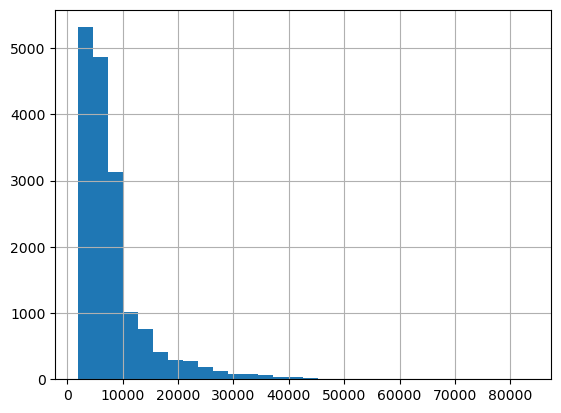

In [561]:
df_loyalty_clean["clv"].hist(bins=30)#para variables numericas


<Axes: >

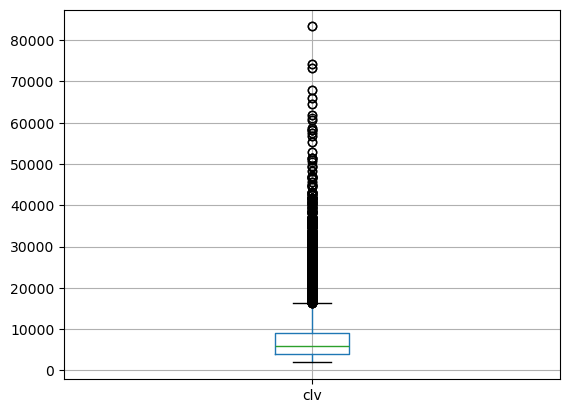

In [562]:
df_loyalty_clean.boxplot(column="clv")


La variable clv presenta una fuerte asimetría positiva. La mediana está muy por debajo de la media en el .describe, mientras que se observan numerosos outliers que superan los 40.000 y llegan hasta 80.000. La mayoría de clientes concentra valores bajos de clv, mientras una minoría muy reducida explica los valores extremos.”

In [563]:
print(df_loyalty_clean["enrollment_type"].isnull().sum())
print(df_loyalty_clean["enrollment_type"].value_counts())


0
enrollment_type
Standard          15766
2018 Promotion      971
Name: count, dtype: int64


La variable enrollment_type no presenta valores nulos. La gran mayoría de clientes (más del 94 %) tienen el tipo de inscripción estándar, mientras que solo un 6 % se inscribió mediante la promoción de 2018. Esto indica que la campaña promocional atrajo a un número reducido de clientes frente al canal habitual.”

In [564]:
revisar_columna(df_loyalty_clean, "enrollment_year")

--- Revisión de enrollment_year ---
Nulos: 0
Negativos: 0
Estadísticas básicas:
count    16737.000000
mean      2015.253211
std          1.979111
min       2012.000000
25%       2014.000000
50%       2015.000000
75%       2017.000000
max       2018.000000
Name: enrollment_year, dtype: float64




La variable enrollment_year no presenta nulos ni valores negativos. Los datos abarcan desde 2012 hasta 2018, con una mediana en 2015. El 50 % de los clientes se inscribió entre 2014 y 2017, lo que indica que la mayor parte de la base de clientes es relativamente reciente. El máximo en 2018 coincide con la campaña de promoción identificada en la variable enrollment_type, lo que refuerza que esa acción generó un pico de nuevas inscripciones.

In [565]:
revisar_columna(df_loyalty_clean, "enrollment_month")

--- Revisión de enrollment_month ---
Nulos: 0
Negativos: 0
Estadísticas básicas:
count    16737.000000
mean         6.669116
std          3.398958
min          1.000000
25%          4.000000
50%          7.000000
75%         10.000000
max         12.000000
Name: enrollment_month, dtype: float64




La variable enrollment_month no presenta nulos ni valores negativos. Los valores van del 1 al 12, lo que confirma que las inscripciones ocurrieron en todos los meses del año. La mediana es 7 (julio) y la media se sitúa en torno a 6,6, lo que indica que las inscripciones están repartidas de forma bastante uniforme a lo largo del año, con un punto central en verano. Los percentiles (25% = abril, 50% = julio, 75% = octubre) refuerzan esta distribución equilibrada.

In [566]:
print("Nulos en cancellation_year:", df_loyalty_clean["cancellation_year"].isna().sum())#cuenta cuanto valores faltantes tiene una columna
print("Valores únicos:", df_loyalty_clean["cancellation_year"].unique())#sirve para ver cuantos valores distintos hay.
print("Cantidad de valores únicos:", df_loyalty_clean["cancellation_year"].nunique())#sirve para inspeccionar que valores aparecen
print("Tipo de dato:", df_loyalty_clean["cancellation_year"].dtype)


Nulos en cancellation_year: 14670
Valores únicos: [  nan 2018. 2015. 2017. 2014. 2016. 2013.]
Cantidad de valores únicos: 6
Tipo de dato: float64


La variable cancellation_year presenta nulos que representan clientes activos. No deben imputarse, ya que aportan información útil para segmentar clientes activos vs. cancelados. Inicialmente Pandas asigna el tipo float64 por la presencia de nulos, pero puede convertirse a Int64 para mejorar la legibilidad sin perder los nulos.

In [567]:
df_loyalty_clean["cancellation_year"] = df_loyalty_clean["cancellation_year"].astype("Int64")


In [568]:
print(df_loyalty_clean["cancellation_year"].dtype)
print(df_loyalty_clean["cancellation_year"].unique())


Int64
<IntegerArray>
[<NA>, 2018, 2015, 2017, 2014, 2016, 2013]
Length: 7, dtype: Int64


In [569]:
print("Nulos en cancellation_month:", df_loyalty_clean["cancellation_month"].isna().sum())
print("Valores únicos:", df_loyalty_clean["cancellation_month"].unique())
print("Cantidad de valores únicos:", df_loyalty_clean["cancellation_month"].nunique())
print("Tipo de dato:", df_loyalty_clean["cancellation_month"].dtype)


Nulos en cancellation_month: 14670
Valores únicos: [nan  1. 12.  4.  2.  7. 11.  5.  6. 10.  8.  9.  3.]
Cantidad de valores únicos: 12
Tipo de dato: float64


cancellation_month presenta 14 670 nulos, que corresponden a clientes que no han cancelado, por lo que estos valores deben interpretarse como “activo” y no imputarse. Los 2 067 registros restantes contienen valores entre 1 y 12, que indican el mes en que se produjo la baja. La variable es consistente, refleja información temporal relevante y, al igual que cancellation_year, los nulos son informativos y útiles para diferenciar entre clientes activos y cancelados.

In [570]:

df_loyalty_clean["cancellation_month"] = df_loyalty_clean["cancellation_month"].astype("Int64")

In [571]:
print(df_loyalty_clean["cancellation_month"].dtype)
print(df_loyalty_clean["cancellation_month"].unique())

Int64
<IntegerArray>
[<NA>, 1, 12, 4, 2, 7, 11, 5, 6, 10, 8, 9, 3]
Length: 13, dtype: Int64


#Uno los dos dataframe en un merge inner para que devuelva unicamente los clientes que aparecen en ambos datasets por la columna loyalty_number.

In [572]:
df_master = pd.merge(
    df_flight_clean, 
    df_loyalty_clean, 
    on="loyalty_number",   # columna común en ambos
    how="inner"            # inner: solo clientes que están en ambos datasets
)


In [573]:
print(df_master.shape)
print(df_master.head())


(405624, 23)
   loyalty_number  year  month  flights_booked  flights_with_companions  \
0          100018  2017      1               3                        0   
1          100102  2017      1              10                        4   
2          100140  2017      1               6                        0   
3          100214  2017      1               0                        0   
4          100272  2017      1               0                        0   

   total_flights  distance  points_accumulated  points_redeemed  \
0              3      1521               152.0                0   
1             14      2030               203.0                0   
2              6      1200               120.0                0   
3              0         0                 0.0                0   
4              0         0                 0.0                0   

   dollar_cost_points_redeemed  ... education   salary marital_status  \
0                            0  ...  Bachelor  92552.0      

In [574]:
print(df_master.shape)                # dimensiones
print(df_master.isnull().sum())       # nulos por columna
print(df_master.duplicated().sum())   # duplicados completos


(405624, 23)
loyalty_number                      0
year                                0
month                               0
flights_booked                      0
flights_with_companions             0
total_flights                       0
distance                            0
points_accumulated                  0
points_redeemed                     0
dollar_cost_points_redeemed         0
province                            0
city                                0
gender                              0
education                           0
salary                              0
marital_status                      0
loyalty_card                        0
clv                                 0
enrollment_type                     0
enrollment_year                     0
enrollment_month                    0
cancellation_year              355560
cancellation_month             355560
dtype: int64
1864


Fase 2: Visualización
¿Cómo se distribuye la cantidad de vuelos reservados por mes durante el año?


In [ ]:
flights_by_month = (df_master.groupby(["year", "month"])["flights_booked"].sum().reset_index())#genera un índice numerico nuevo
print(flights_by_month)

    year  month  flights_booked
0   2017      1           47766
1   2017      2           47691
2   2017      3           64271
3   2017      4           55720
4   2017      5           65279
5   2017      6           80493
6   2017      7           89288
7   2017      8           78692
8   2017      9           63304
9   2017     10           60351
10  2017     11           56905
11  2017     12           77650
12  2018      1           49170
13  2018      2           48643
14  2018      3           66928
15  2018      4           56791
16  2018      5           76891
17  2018      6           92749
18  2018      7          104143
19  2018      8           90512
20  2018      9           73075
21  2018     10           69110
22  2018     11           65345
23  2018     12           88397


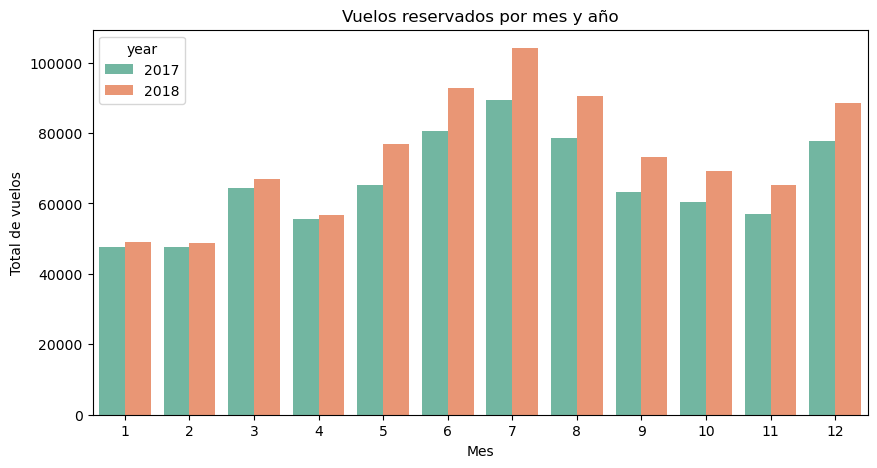

In [576]:
#Grafico de barras agrupadas que le va mejor a las variables numerica+temporales.


plt.figure(figsize=(10,5))
sns.barplot(x="month", y="flights_booked", hue="year", data=flights_by_month,palette="Set2")
plt.title("Vuelos reservados por mes y año")
plt.xlabel("Mes")
plt.ylabel("Total de vuelos")
plt.show()

Los vuelos reservados se distribuyen regularmente a lo largo de los meses con un aumento claro en verano y Diciembre y con picos en Agosto. Al comparar los años, 2018 presenta en la mayoría de los meses un mayor número de reservas que 2017, lo que indica un crecimiento en la actividad del programa de fidelización.

¿Existe una relación entre la distancia de los vuelos y los puntos acumulados por los cliente?

In [592]:
print(df_flight_grouped[["distance","points_accumulated"]].corr())


                    distance  points_accumulated
distance             1.00000             0.99453
points_accumulated   0.99453             1.00000


<Axes: xlabel='distance', ylabel='points_accumulated'>

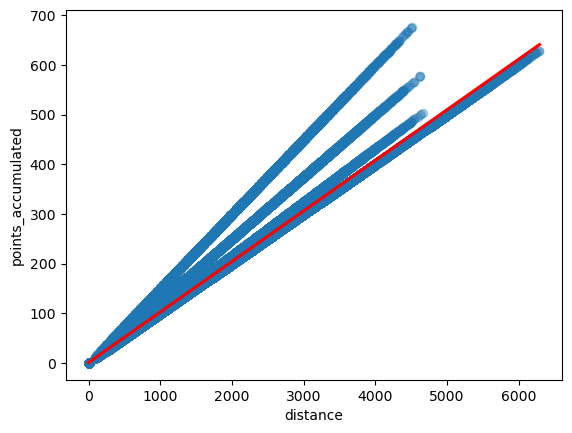

In [ ]:
#Scatter plot con linea de regresion. Para comprobar si dos variables numerica tienen correlacion
sns.regplot(
    x="distance", y="points_accumulated",
    data=df_master,
    scatter_kws={"alpha":0.3},   # puntos transparentes
    line_kws={"color":"red"}     # línea de tendencia en rojo
)



En el gráfico aparecen varias líneas porque los clientes tienen diferentes reglas de acumulación de puntos según su perfil o tipo de tarjeta. Por eso no todos convierten la misma distancia en la misma cantidad de puntos. Cada lineas son muchos clientes que siguen una misma proporcion y son diferentes entre ellas. 
A mayor distancia volada, más puntos acumulados. Las distintas líneas reflejan que existen categorías de clientes, lo cual es coherente con un programa de fidelización.

¿Cuál es la distribución de los clientes por provincia o estado?

In [578]:
flights_by_month = (df_master.groupby(["province"])["loyalty_number"].nunique().reset_index()) #nunique cuenta los clientes unicos por provincia.
clients_by_province = df_master.groupby("province")["loyalty_number"].nunique().reset_index()


C:\Users\elaru\AppData\Local\Temp\ipykernel_12728\3715624571.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="loyalty_number", y="province", data=clients_by_province, palette="magma")


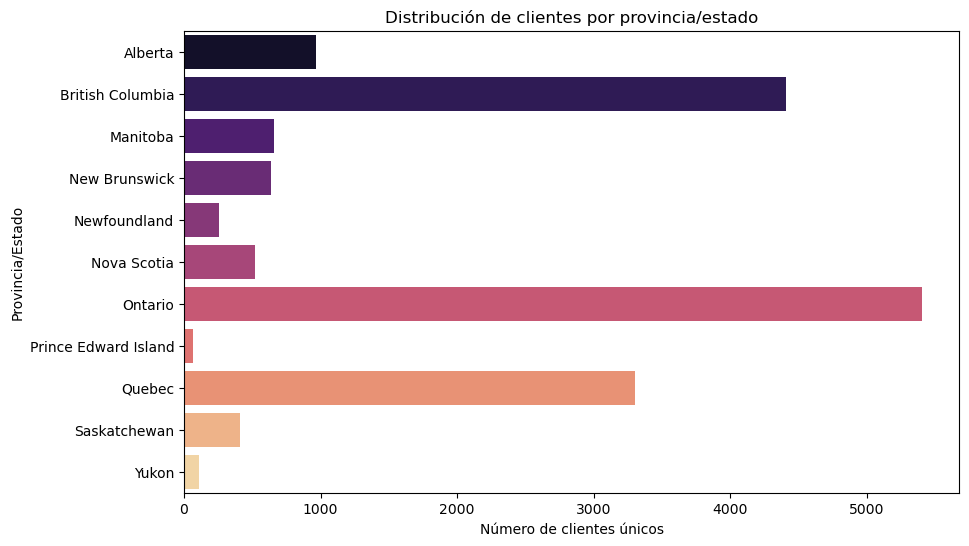

In [ ]:
# Gráfico de barras horizontal. Para representar variables categóricas y comparar cantidades facilmente.
plt.figure(figsize=(10,6))
sns.barplot(x="loyalty_number", y="province", data=clients_by_province, palette="magma")
plt.title("Distribución de clientes por provincia/estado")
plt.xlabel("Número de clientes únicos")
plt.ylabel("Provincia/Estado")
plt.show()

El grafico parece un reflejo demográfico del pais.La base de clientes está concentrada principalmente en las provincias más pobladas y económicamente activas (Ontario, Quebec, British Columbia).Los mercados grandes aportan la mayor parte de clientes, mientras que los estados pequeños apenas contribuyen.

¿Cómo se compara el salario promedio entre los diferentes niveles educativos de los clientes?

In [580]:
clients = df_master.drop_duplicates(subset=["loyalty_number"]) # esto me evita duplicados.mi dataframe cuenta por actividad asi que un mismo cliente aparece varias veces.
clients_by_education = clients.groupby("education")["salary"].mean().reset_index()

<Axes: xlabel='education', ylabel='salary'>

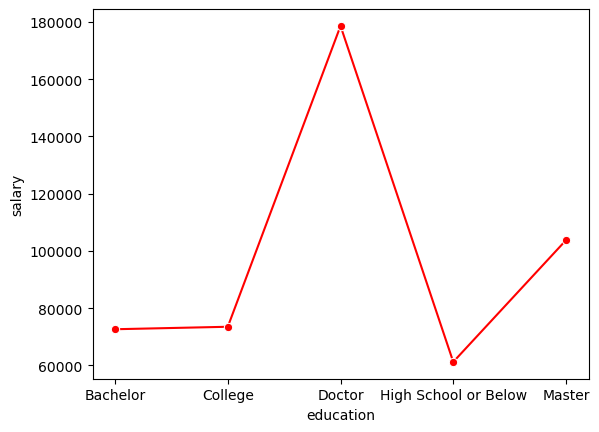

In [ ]:
#Gráfico de líneas para comparar una variable numerica con una categorica.
sns.lineplot(x="education", y="salary", data=clients_by_education, marker="o" , color="red")


El salario promedio aumenta de forma consistente con el nivel educativo. Los clientes con doctorado perciben los salarios más altos, mientras que quienes solo tienen secundaria o menos registran los más bajos.

¿Cuál es la proporción de clientes con diferentes tipos de tarjetas de fidelidad? 

In [594]:

clients = df_master.drop_duplicates(subset=["loyalty_number"])#le dice a panda que deje solo una fila por cliente
clients_by_loyalty_card = clients["loyalty_card"].value_counts(normalize=True) * 100 
#si no pones normalize True solo devuelve el numero de clientes por tarjeta no la proporción



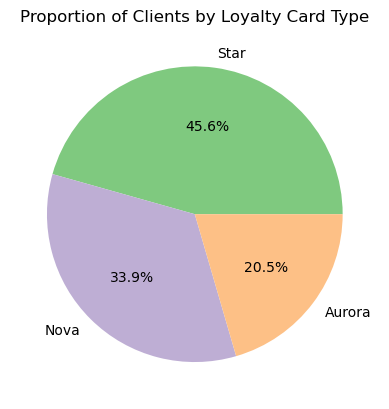

In [ ]:
#Pie chart. Útil para comparar variables categóricas y el peso de las categorias dentro del total.
clients_by_loyalty_card.plot(kind="pie",autopct="%.1f%%",ylabel="",  # quita el label lateral feo
    colors=sns.color_palette("Accent"))
plt.title("Proportion of Clients by Loyalty Card Type")
plt.show()


La mayoría de los clientes posee la tarjeta Star (aprox.45%), seguida por la tarjeta Nova (≈34%). La tarjeta Aurora concentra la menor proporción de clientes (≈20%). Esto indica que Star es la modalidad predominante en la base de clientes.

¿Cómo se distribuyen los clientes según su estado civil y género?

In [584]:

clients = df_master.drop_duplicates(subset=["loyalty_number"])
clients_by_status_gender = clients.groupby(["marital_status", "gender"])["loyalty_number"].count().reset_index()

print(clients_by_status_gender)



  marital_status  gender  loyalty_number
0       Divorced  Female            1269
1       Divorced    Male            1249
2        Married  Female            4869
3        Married    Male            4866
4         Single  Female            2272
5         Single    Male            2212


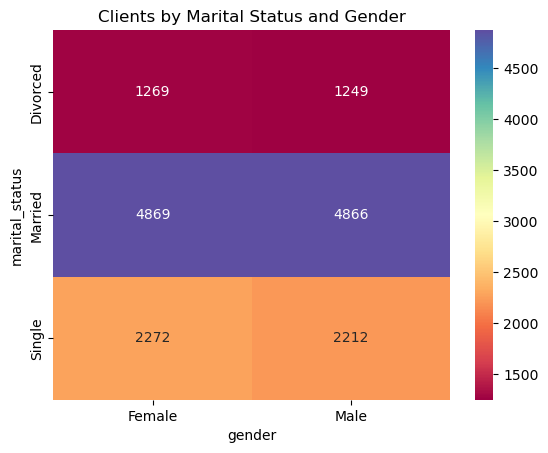

In [ ]:
#Barras apiladas que 
crosstab = pd.crosstab(clients["marital_status"], clients["gender"])
sns.heatmap(crosstab, annot=True, fmt="d", cmap="Spectral")
plt.title("Clients by Marital Status and Gender")
plt.show()

La distribución por género es muy equilibrada en todos los estados civiles. La mayor parte de los clientes son casados, mientras que los solteros y divorciados representan proporciones menores y similares entre sí.

BONUS Fase 3: Evaluación de Diferencias en Reservas de Vuelos por Nivel Educativo

In [586]:
# Filtrar columnas relevantes y clientes únicos
clients = df_master.drop_duplicates(subset=["loyalty_number"])
flights_by_education = clients[["flights_booked", "education"]]


In [587]:

#Funcion de Estadisticas descriptivas
def descriptive_stats_by_group(df, group_col, value_col):
    """
    Calcula estadísticas descriptivas agrupadas:
    - count
    - mean
    - median
    - mode
    - std (desviación estándar)
    
    Devuelve un DataFrame con un resumen por cada grupo.
    """
    grouped = df.groupby(group_col)[value_col]
    
    count = grouped.count()
    mean = grouped.mean()
    median = grouped.median()
    mode = grouped.apply(lambda x: x.mode().iloc[0])  # primer valor si hay empate
    std = grouped.std()

    result = pd.DataFrame({
        "count": count,
        "mean": mean,
        "median": median,
        "mode": mode,
        "std": std
    })
    
    return result



In [588]:
clients = df_master.drop_duplicates(subset=["loyalty_number"])
flights_by_education = clients[["flights_booked", "education"]]

desc_stats = descriptive_stats_by_group(flights_by_education, "education", "flights_booked")
print(desc_stats)


                      count      mean  median  mode       std
education                                                    
Bachelor              10475  2.840477     0.0     0  4.015799
College                4238  2.875885     0.0     0  4.021617
Doctor                  734  2.956403     0.0     0  4.223724
High School or Below    782  2.882353     0.0     0  4.105706
Master                  508  2.962598     0.0     0  4.252459


In [589]:
#Función Prueba de hipótesis
def prueba_hipotesis(*args):
    """
    Realiza una prueba de hipótesis para comparar grupos.
    1. Primero verifica si los datos son normales usando el test de Shapiro-Wilk o Kolmogorov-Smirnov.
    2. Si los datos son normales, usa Bartlett para probar igualdad de varianzas. Si no son normales, usa Levene.
    3. Si las varianzas son iguales, usa el t-test de Student; si no, usa la versión de Welch.
    4. Si los datos no son normales, usa el test de Mann-Whitney

    Parámetros:
    *args: listas o arrays con los datos de cada grupo. Espera DOS grupos a comparar

    Retorna:
    dict con resultados del test de normalidad, varianza e hipótesis.
    """
    if len(args) < 2:
        raise ValueError("Se necesitan al menos dos conjuntos de datos para realizar la prueba.")
    
    normalidad = []
    for grupo in args:
        if len(grupo) > 50:
            p_valor_norm = stats.kstest(grupo, 'norm').pvalue
        else:
            p_valor_norm = stats.shapiro(grupo).pvalue
        normalidad.append(p_valor_norm > 0.05)

    datos_normales = all(normalidad)

    if datos_normales:
        p_valor_varianza = stats.bartlett(*args).pvalue
    else:
        p_valor_varianza = stats.levene(*args, center="median").pvalue

    varianzas_iguales = p_valor_varianza > 0.05

    if datos_normales:
        if varianzas_iguales:
            t_stat, p_valor = stats.ttest_ind(*args, equal_var=True)
            test_usado = "t-test de Student (varianzas iguales)"
        else:
            t_stat, p_valor = stats.ttest_ind(*args, equal_var=False)
            test_usado = "t-test de Welch (varianzas desiguales)"
    else:
        t_stat, p_valor = stats.mannwhitneyu(*args)
        test_usado = "Mann-Whitney U"

    alfa = 0.05
    resultado = {
        "Test de Normalidad": normalidad,
        "Datos Normales": datos_normales,
        "p-valor Varianza": p_valor_varianza,
        "Varianzas Iguales": varianzas_iguales,
        "Test Usado": test_usado,
        "Estadístico": t_stat,
        "p-valor": p_valor,
        "Conclusión": "Rechazamos H0. Es decir, sí hay diferencias significativas)" if p_valor < alfa else "No se rechaza H0. Es decir, no hay diferencias significativas)"
    }

    print("\n📊 **Resultados de la Prueba de Hipótesis** 📊")
    print(f"✅ Test de Normalidad: {'Sí' if datos_normales else 'No'}")
    print(f"   - Normalidad por grupo: {normalidad}")
    print(f"✅ Test de Varianza: {'Iguales' if varianzas_iguales else 'Desiguales'} (p = {p_valor_varianza:.4f})")
    print(f"✅ Test aplicado: {test_usado}")
    print(f"📉 Estadístico: {t_stat:.4f}, p-valor: {p_valor:.4f}")
    print(f"🔍 Conclusión: {resultado['Conclusión']}\n")
    return resultado

# === PREPARACIÓN DE DATOS (tus variables) ===
# Un cliente por loyalty_number y columnas relevantes
clients = df_master.drop_duplicates(subset=["loyalty_number"])
df = clients[["education", "flights_booked"]].dropna()

# === (Opcional) PRUEBA GLOBAL: ANOVA entre ≥3 niveles ===
if df["education"].nunique() >= 3:
    grupos = [df.loc[df["education"] == e, "flights_booked"].values for e in sorted(df["education"].unique())]
    F, p_anova = stats.f_oneway(*grupos)
    print(f"ANOVA global: F={F:.4f}, p={p_anova:.4g}")

# === PRUEBAS PAREADAS CON TU FUNCIÓN + BONFERRONI ===
niveles = sorted(df["education"].unique())
pares = list(combinations(niveles, 2))
alpha_bonf = 0.05 / len(pares) if pares else 0.05
print(f"Alpha Bonferroni: {alpha_bonf:.4g}")


resultados_pareados = []
for a, b in pares:
    g1 = df.loc[df["education"] == a, "flights_booked"].values
    g2 = df.loc[df["education"] == b, "flights_booked"].values
    res = prueba_hipotesis(g1, g2)
    resultados_pareados.append({
        "grupo_A": a,
        "grupo_B": b,
        "p_valor": res["p-valor"],
        "test": res["Test Usado"],
        "significativo_Bonferroni": res["p-valor"] < alpha_bonf
    })

pd.DataFrame(resultados_pareados)


ANOVA global: F=0.2701, p=0.8973
Alpha Bonferroni: 0.005

📊 **Resultados de la Prueba de Hipótesis** 📊
✅ Test de Normalidad: No
   - Normalidad por grupo: [np.False_, np.False_]
✅ Test de Varianza: Iguales (p = 0.6283)
✅ Test aplicado: Mann-Whitney U
📉 Estadístico: 22075864.5000, p-valor: 0.5686
🔍 Conclusión: No se rechaza H0. Es decir, no hay diferencias significativas)


📊 **Resultados de la Prueba de Hipótesis** 📊
✅ Test de Normalidad: No
   - Normalidad por grupo: [np.False_, np.False_]
✅ Test de Varianza: Iguales (p = 0.4512)
✅ Test aplicado: Mann-Whitney U
📉 Estadístico: 3839738.5000, p-valor: 0.9524
🔍 Conclusión: No se rechaza H0. Es decir, no hay diferencias significativas)


📊 **Resultados de la Prueba de Hipótesis** 📊
✅ Test de Normalidad: No
   - Normalidad por grupo: [np.False_, np.False_]
✅ Test de Varianza: Iguales (p = 0.7788)
✅ Test aplicado: Mann-Whitney U
📉 Estadístico: 4088579.0000, p-valor: 0.9283
🔍 Conclusión: No se rechaza H0. Es decir, no hay diferencias signific

,grupo_A,grupo_B,p_valor,test,significativo_Bonferroni
0,Bachelor,College,0.568650,Mann-Whitney U,False
1,Bachelor,Doctor,0.952377,Mann-Whitney U,False
2,Bachelor,High School or Below,0.928344,Mann-Whitney U,False
3,Bachelor,Master,0.969061,Mann-Whitney U,False
4,College,Doctor,0.853139,Mann-Whitney U,False
5,College,High School or Below,0.862049,Mann-Whitney U,False
6,College,Master,0.853093,Mann-Whitney U,False
7,Doctor,High School or Below,0.978843,Mann-Whitney U,False
8,Doctor,Master,0.990734,Mann-Whitney U,False
9,High School or Below,Master,0.984739,Mann-Whitney U,False


Con esta muestra no se encontraron diferencias significativas.

In [590]:
def confidence_interval_pretty(df, group_col, value_col, confidence=0.95):
    results = []
    for nivel, datos in df.groupby(group_col)[value_col]:
        n = len(datos)
        mean_val = datos.mean()
        std_val = datos.std(ddof=1)

        # margen de error
        margin_error = stats.t.ppf((1 + confidence) / 2, df=n-1) * (std_val / np.sqrt(n))

        results.append({
            group_col: nivel,
            "mean": round(mean_val, 2),
            f"IC_{int(confidence*100)}%": f"{mean_val:.2f} ± {margin_error:.2f}"
        })
    
    return pd.DataFrame(results)

In [591]:
ci_df = confidence_interval_pretty(flights_by_education, "education", "flights_booked")
print(ci_df)#la funcion de la profe dejó el intervalo de confianza en el rango. yo lo convertí a la media. 

              education  mean       IC_95%
0              Bachelor  2.84  2.84 ± 0.08
1               College  2.88  2.88 ± 0.12
2                Doctor  2.96  2.96 ± 0.31
3  High School or Below  2.88  2.88 ± 0.29
4                Master  2.96  2.96 ± 0.37


Se analizó si existían diferencias en el número de vuelos reservados según el nivel educativo. Los resultados de las pruebas de hipótesis (Mann-Whitney U) mostraron que no hay diferencias estadísticamente significativas entre los grupos (p-valores > 0.05).
Además, los intervalos de confianza al 95% de las medias de cada nivel educativo se solapan ampliamente (por ejemplo, Bachelor: 2.84 ± 0.08; Doctor: 2.96 ± 0.31), lo que refuerza la conclusión de que el nivel educativo no influye de manera significativa en el número de vuelos reservados.

## Conclusión global

El análisis del dataset muestra que la mayoría de clientes son casados y que la distribución por género es equilibrada. La tarjeta de fidelidad *Star* concentra la mayor proporción de clientes, mientras que *Nova* ocupa el segundo lugar y *Aurora* es minoritaria.  

En el plano socioeconómico, el salario promedio aumenta con el nivel educativo, aunque este factor no influye significativamente en el número de vuelos reservados, según el análisis inferencial realizado.  

En conjunto, los resultados sugieren que el comportamiento de fidelidad está más condicionado por factores comerciales (tipo de tarjeta de fidelidad) que por características demográficas o educativas.  
